# Założenia
Celem projektu jest stworzenie skryptu generującego profil terenu z cyfrowego modelu terenu (DEM) w formacie (Geo)Tiff dla linii o zadanym punkcie początkowym, długości i azymucie.

Realizacja zadania będzie wymagała następujących etapów:

1. Określenie linii przekroju.
    1. Wyznaczenie funkcji liniowej o zadanym współczynniku kierunkowym (wyrażonym przez tangens kąta azymutu).
    2. Rozwiązanie problemów z zapisem kąta azymutu.
2. Wczytanie modelu terenu.
3. Odczytanie wysokości wzdłuż zdefiniowanej linii profilu.
4. Wykreślenie profilu.

## 1. Import modułów

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import rasterio

## 2. Linia przekroju
Ogólne równanie prostej to *y = ax + b*, gdzie:
    *a*: współczynnik kierunkowy prostej, *a = tan(alfa)*, gdzie:
        *alfa* - kąt nachylenia prostej do osi x
    *b*: określa przesunięcie prostej wzdłuż osi y; na razie przyjmiemy *b=0*

Trzy funkcje poniżej służą do: 
1. rysowania linii o zadanych współczynnikach
2. obliczania współczynnika kierunkowego dla prostej o zadanym azymucie
3. rysowaniu linii o zadanym azymucie.

In [2]:
def rysuj_linie(a = 1, b = 0):
    '''
    Rysuje prostą o zadanych współczynnikach a, b.
    '''
    x = np.linspace(1,10)
    y = a * x + b
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.axis('equal')
    plt.show()

In [3]:
def wsp_kier_z_azymutu(azymut):
    '''
    Określa współczynnik kierunkowy prostej o danym azymucie
    
    Args:
        azymut (int): azymut prostej, w stopniach
        
    Returns:
        float: współczynnik kierunkowy prostej
    
    '''
    if azymut > 180:
        azymut -= 180
    alfa = 90 - azymut
    alfa = (alfa * np.pi)/180
    return(np.tan(alfa))

In [4]:
def linia_z_azymutu(azymut):
    '''
    Rysuje prostą o zadanym azymucie
    '''
    a = wsp_kier_z_azymutu(azymut)
    rysuj_linie(a)

Testowanie funkcji

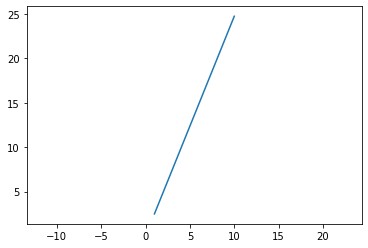

In [5]:
linia_z_azymutu(22)

## 3. Wczytywanie i wyświetlanie modelu

Do otwarcia rastra z georeferencjami służy funkcja *open* z modułu *rasterio*, a więc dostęp do niej mamy wywołaniem *rasterio.open()* Funkcja ta nie wczytuje rastra, tworzy tylko do niego dowiązanie, które nazwiemy *src*. Następnie, po otwarciu rastra musimy go wczytać do zmiennej *dem*, za pomocą funkcji read. Warto zauważyć, że *read* jest już funkcją (metodą) utworzonego dowiązania do rastra o nazwie *src*.

Finalna zmienna, *dem* jest typu ndarray, pochodzącego z modułu numpy; jest to więc typ przechowujący macierz. I faktycznie - obraz jest przecież macierzą 👀.

In [6]:
plik_rastra = 'dane/dem.tif'

In [7]:
with rasterio.open(plik_rastra) as src:
    dem = src.read(1)

In [8]:
type(dem)

numpy.ndarray

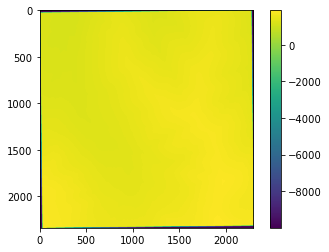

In [9]:
plt.imshow(dem)
plt.colorbar()

Jak widać, udało się, ale zakres wysokości jest od prawie że Rowu Mariańskiego do nieco ponad 0. Wynika to z tego, że w użytych danych jako -9999 zakodowany jest brak danych.

Skąd braki danych?
Każdy raster musi być prostokątem ułożonym równolegle do osi układu współrzędnych. Model natomiast jest w formie "kafelków" które są nieco zrotowane względem tego układu, stąd przy krawędziach pojawiają się wąziutkie kliny z brakiem danych.

Otworzymy teraz jeszcze raz plik, ustawiając maskowanie wartości -9999.

In [10]:
with rasterio.open(plik_rastra,'r+') as src:
    src.nodata = -9999
    dem = src.read(1,masked=True)

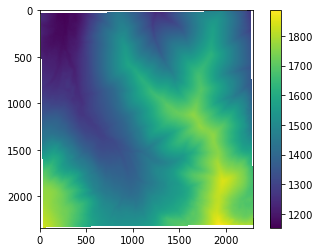

In [11]:
plt.imshow(dem)
plt.colorbar()

Układ współrzędnych

In [12]:
with rasterio.open(plik_rastra,'r+') as src:
    src.nodata = -9999
    dem.crs = rasterio.crs.CRS.from_epsg(2180)




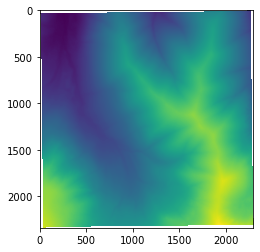

In [13]:
plt.imshow(dem)

## 4. Odczytujemy dane z modelu

Możemy teraz sprawdzić wysokość dowolnego punktu w obszarze naszego rastra podając jego współrzędne. Póki co pracujemy w lokalnym układzie współrzędnych, powiązanych z danym rastrem - zignorowaliśmy w jakim układzie współrzędnych nasz raster jest tak naprawdę (a jest to układ 19... o kodzie EPSG 21... - to już wiecie sami!)

In [14]:
x = 100
y = 1242

dem[x,y]

1280.16

In [15]:
type(dem)

numpy.ma.core.MaskedArray

Zróbmy teraz funkcję do sprawdzania wysokości

In [16]:
def sprawdz_wysokosc(model,x,y):
    z = model[x,y]
    print(f"Wysokość punktu {z} m n.p.m")
    return z

In [18]:
wysokosc = sprawdz_wysokosc(dem,543,232)

Wysokość punktu 1205.9599609375 m n.p.m


Dzięki temu, że model przekazujemy do naszej funkcji jako argument, można ją wygodnie wykorzystać wielokrotnie - możemy np. mieć kilka modeli o różnych nazwach i na każdym z nich wywoływać *sprawdz_wysokosc*.

## ciąg dalszy nastąpi...